<a href="https://colab.research.google.com/github/kevinchensunshine/spintest/blob/main/SPINTEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tifffile
!pip install torch

# Visualizing the Data

In [ ]:
import tifffile
import numpy as np

#load the data into numpy arrays
tiff_data = tifffile.imread('20130824_RE3_3A_Analytic_Champaign_north.tif')
cdl_data = tifffile.imread('CDL_2013_Champaign_north.tif')
tiff_data.shape
cdl_data.shape

(5959, 9425)

Let's take a look at the values

In [ ]:
print(tiff_data[:5, :1])
print(cdl_data[:5, :5])

#Show some nonzero values
print(tiff_data[(tiff_data != 0)][:5])
max_index = np.unravel_index(np.argmax(tiff_data), tiff_data.shape)
print(tiff_data[max_index[0], max_index[1]])

[[[0 0 0 0 0]]

 [[0 0 0 0 0]]

 [[0 0 0 0 0]]

 [[0 0 0 0 0]]

 [[0 0 0 0 0]]]
[[5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]]
[5231 3905 2146 3097 8315]
<class 'tuple'>
[35709 35178 30663 24363 23782]


We see that the maximum pixel value is 35709. This seems to fit with the 16-bit unsigned color values, which may be important in visualizations and the model itself

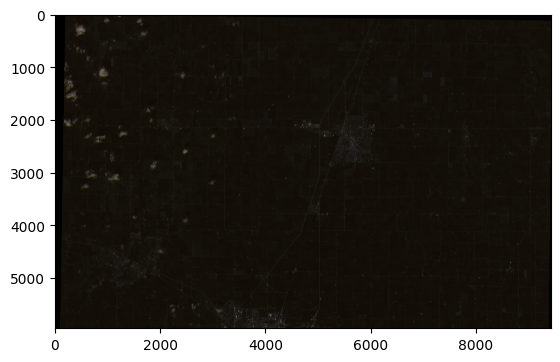

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#Get the image in a matplotlib-friendly pixel format
rgb_image = tiff_data[:, :, :3] / 65536.0
plt.imshow(rgb_image)
plt.show()

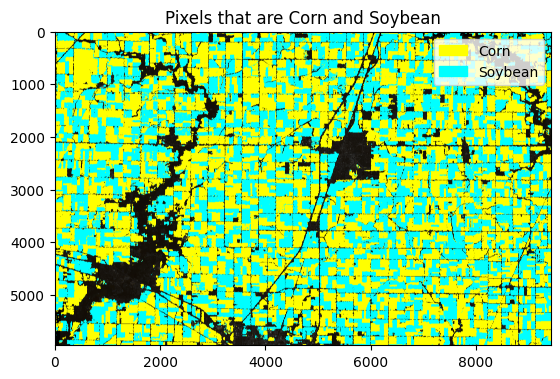

In [ ]:
#Highlight the pixels that are corn and soybeans
corn_bool_matrix = cdl_data == 1
soybean_bool_matrix = cdl_data == 5
rgb_image[corn_bool_matrix] = np.array([1, 1, 0])
rgb_image[soybean_bool_matrix] = np.array([0, 1, 1])


corn_patch = mpatches.Patch(color='yellow', label='Corn')
soybean_patch = mpatches.Patch(color='cyan', label='Soybean')
plt.legend(handles=[corn_patch, soybean_patch])

plt.title("Pixels that are Corn and Soybean")
plt.imshow(rgb_image)
plt.show()

# Data Cleaning
Most of the data is already cleaned so that it overlaps with the training data. However, because the classification only deals with corn, soybeans, and other, I decided to normalize these values. As such, the algorithm doesn't need to identify features in other crops

In [ ]:
#Turn all corn pixels into 0, all soybean pixels into 1, and everything else to 2
cdl_data = np.where(cdl_data == 1, 0, np.where(cdl_data == 5, 1, 2))

For the primary algorithm I'll be using, Decision Trees, I won't need to normalize the base values themselves as I don't have to deal with gradient descent

In [ ]:
def flatten_to_train(tiff_data, cdl_data):
  return (tiff_data.reshape(-1, 5), cdl_data.reshape(-1))

# Models
After a little bit of testing, I found that with the size of the dataset, performance was a large bottleneck. I first wanted to find a model that could run on the raw dataset constrained by Colab's free tier. After a little trial and error, I got Decisions Trees to work. I chose this for its relatively strong hardware performance, as well as being decently good at classification. Even with this, I needed to partition the training data size to be relatively small (1/2) so that the model would train within the given RAM

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Flatten the tiff_data into 2D and the corresponding labels
tiff_data, cdl_data = flatten_to_train(tiff_data, cdl_data)

# Define the Decision Tree classifier
classifier = DecisionTreeClassifier()

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(tiff_data, cdl_data, test_size=0.5, random_state=42)

# Train the Decision Tree classifier
classifier.fit(X_train, y_train)

# Predict labels on the validation set
y_pred = classifier.predict(X_valid)


from joblib import dump
dump(classifier, 'decision_tree_classifier.joblib')

Validation Accuracy: 0.7446


['decision_tree_classifier.joblib']

# Evaluation
Importing the south image, we can infer the labels and display them

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.7446


0.7446 implies that the inference has a general hueristic to predict pixels, but certainly has issues.

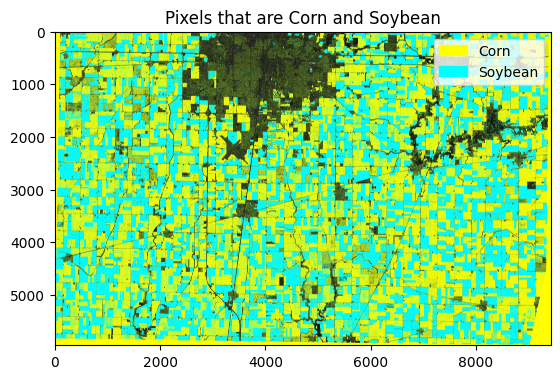

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import joblib

bottom_half = tifffile.imread("20130824_RE3_3A_Analytic_Champaign_south.tif")
bottom_half = bottom_half.reshape(-1, 5)

decision_tree = joblib.load('decision_tree_classifier.joblib')

labels = decision_tree.predict(bottom_half)

bottom_half = bottom_half.reshape(5959, 9425, 5)
labels = labels.reshape(5959, 9425)

bottom_half = bottom_half[:,:,:3] / 65536.0
bottom_half[labels == 0] = np.array([1, 1, 0])
bottom_half[labels == 1] = np.array([0, 1, 1])

corn_patch = mpatches.Patch(color='yellow', label='Corn')
soybean_patch = mpatches.Patch(color='cyan', label='Soybean')
plt.legend(handles=[corn_patch, soybean_patch])

plt.title("Pixels that are Corn and Soybean")
plt.imshow(bottom_half)
plt.show()

As expected, there are plenty of patches of each crop that are placed around the image. Another notable thing is that the model identifies the background edges of the image as corn. Some patches seem to not be labeled as either corn or soybean. This may potentially show bias in the model, as normalizing all non-corn-soybean values to 2 causes a wide range of values to be classified as "other". This may make it very sensitive to outliers within both corn and soybean.